# Using `xbatcher` to train an autoencoder

---

## Imports

In [1]:
import os

# DL stuff
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

torch.set_default_dtype(torch.float64)

# Geospatial stuff
import xarray as xr
import xbatcher
import rioxarray
import xbatcher
from xbatcher.loaders.torch import MapDataset

# Etc
import numpy as np
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

/tmp/ipykernel_2051/1596326319.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Get data

We will start by pulling a segment of NASADEM for Washington's Olympic peninsula.

In [2]:
# Rasterio adds a blank edge. Trim these out.
dem = rioxarray.open_rasterio("../ASTGTMV003_N47W124_dem.tif")
dem = dem.isel(y=slice(0, -1), x=slice(0, -1))
dem = (dem - dem.min()) / (dem.max() - dem.min())
dem

<xarray.DataArray (band: 1, y: 3600, x: 3600)> Size: 104MB
array([[[0.23102867, 0.23608769, 0.23988196, ..., 0.10581788,
         0.10961214, 0.11298482],
        [0.23229342, 0.2386172 , 0.24283305, ..., 0.11045531,
         0.11340641, 0.1163575 ],
        [0.23102867, 0.23819562, 0.24325464, ..., 0.11467116,
         0.1163575 , 0.11804384],
        ...,
        [0.00252951, 0.00252951, 0.00252951, ..., 0.03752108,
         0.03625632, 0.03752108],
        [0.00252951, 0.00252951, 0.00252951, ..., 0.03625632,
         0.03499157, 0.03878583],
        [0.0029511 , 0.0029511 , 0.0029511 , ..., 0.03667791,
         0.03625632, 0.04005059]]], shape=(1, 3600, 3600))
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 29kB -124.0 -124.0 -124.0 ... -123.0 -123.0 -123.0
  * y            (y) float64 29kB 48.0 48.0 48.0 48.0 ... 47.0 47.0 47.0 47.0
    spatial_ref  int64 8B 0

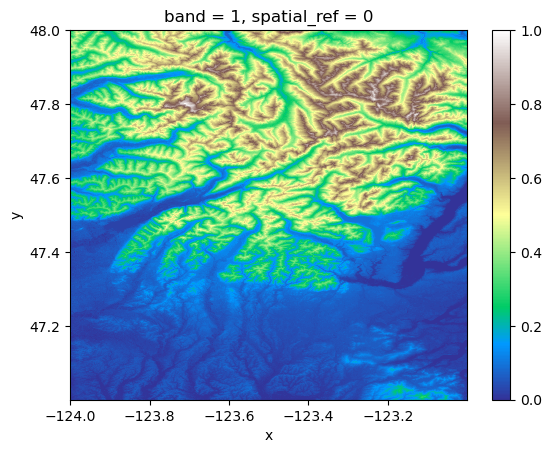

In [3]:
dem.isel(band=0).plot.imshow(cmap="terrain")

## Generate training examples
Here, we use xbatcher to window patches of terrain in the same location.

In [4]:
bgen_x = xbatcher.BatchGenerator(
    dem,
    input_dims=dict(x=32, y=32),
    input_overlap=dict(x=16, y=16)
)

ds = MapDataset(
    X_generator=bgen_x,)

loader = torch.utils.data.DataLoader(ds, batch_size=16, shuffle=True)

In [5]:
X = next(iter(loader))

print("Input tensor shape:", X.shape)

Input tensor shape: torch.Size([16, 1, 32, 32])


## Model setup

In [6]:
import autoencoder
from importlib import reload
reload(autoencoder)

m = autoencoder.Autoencoder(base_channel_size=32, latent_dim=64, num_input_channels=1, width=32, height=32)
opt = m._configure_optimizers()

In [7]:
out = m(X)
print(out.shape)

torch.Size([16, 1, 32, 32])


## Model training

We aren't using pytorch-lightning here to keep the notebook environment lean. For your project, we highly recommend using a framework to abstract away much of the boilerplate code below.

In [8]:
def train_one_epoch(epoch_index):
    last_loss = 0.
    running_loss = 0.
    
    for i, batch in enumerate(tqdm(loader)):
        # Zero your gradients for every batch!
        opt.zero_grad()

        # Make predictions for this batch
        outputs = m(batch)

        # Compute the loss and its gradients
        loss = m._get_reconstruction_loss(batch, outputs)
        loss.backward()
        running_loss += loss.item()

        # Adjust learning weights
        opt.step()

    return running_loss / len(loader)

In [9]:
n_epochs = 5
for i_epoch in range(n_epochs):
    loss = train_one_epoch(i_epoch)
    print(f"Epoch {i_epoch+1:>3}: {loss:.3e}")

  0%|          | 0/3136 [00:00<?, ?it/s]

Epoch   1: 7.634e-01


  0%|          | 0/3136 [00:00<?, ?it/s]

Epoch   2: 1.100e-01


  0%|          | 0/3136 [00:00<?, ?it/s]

Epoch   3: 5.305e-02


  0%|          | 0/3136 [00:00<?, ?it/s]

Epoch   4: 4.712e-02


  0%|          | 0/3136 [00:00<?, ?it/s]

Epoch   5: 3.692e-02


:::{danger}
This model is certainly overfitted. For brevity we have omitted a validation dataset, which is essential for building models that generalize well on unseen data.
:::

In [10]:
m.eval()
n_examples = 4
inputs = next(iter(loader))
outputs = m(inputs)

inputs = inputs.detach().cpu().numpy()
outputs = outputs.detach().cpu().numpy()

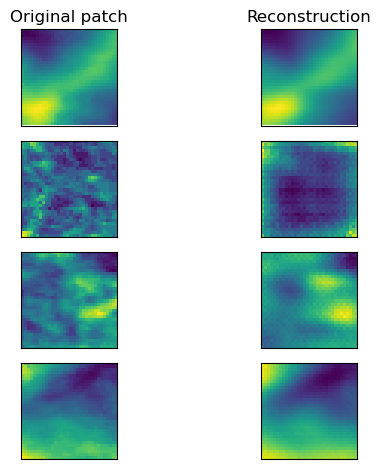

In [11]:
fig, axes = plt.subplots(n_examples, 2)

for i_row in range(n_examples):
    axes[i_row, 0].imshow(inputs[i_row, 0, ...])
    axes[i_row, 1].imshow(outputs[i_row, 0, ...])

for a in axes.flat:
    a.set_xticks([])
    a.set_yticks([])

axes[0, 0].set_title("Original patch")
axes[0, 1].set_title("Reconstruction")

fig.tight_layout()
plt.show()

## Reconstruction 1: Getting the full array back

Suppose we would like to evaluate how the autoencoder does on reconstructing the entire terrain patch by combining outputs across all input patches. To do so we can use the `predict_on_array` function described in the previous notebook. Our model outputs tensors with shape `(band=1, x=32, y=32)`. We need to specify each of these axes in the call to `predict_on_array`. `channel` does not change size and is not used by the `BatchGenerator`, so it goes in `core_dim`. Both `x` and `y` are used by the `BatchGenerator`, so although they do not change size they still go in `resample_dim`. That accounts for all tensor axes, so we can leave the `new_dim` argument as an empty list.

In [12]:
import functions
reload(functions)

<module 'functions' from '/home/jovyan/xbatcher-deep-learning/notebooks/functions.py'>

In [13]:
dem_reconst = functions.predict_on_array(
    dataset=ds,
    model=m,
    output_tensor_dim=dict(band=1, y=32, x=32),
    new_dim=[],
    core_dim=["band"],
    resample_dim=["x", "y"]
)

100%|██████████| 3136/3136 [01:26<00:00, 36.18it/s]


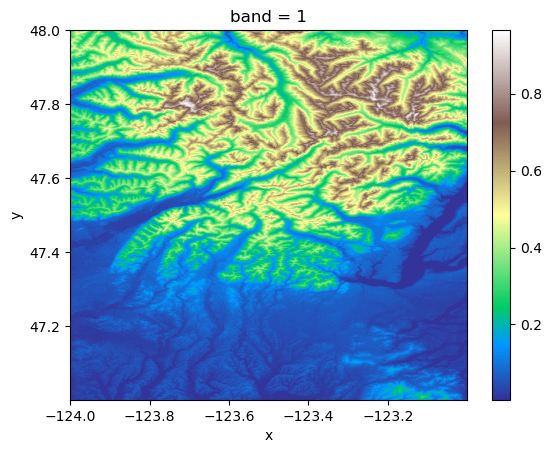

In [14]:
dem_reconst.isel(band=0).plot.imshow(cmap="terrain")

That certainly looks like the original DEM. Let's try plotting the error in the reconstruction.

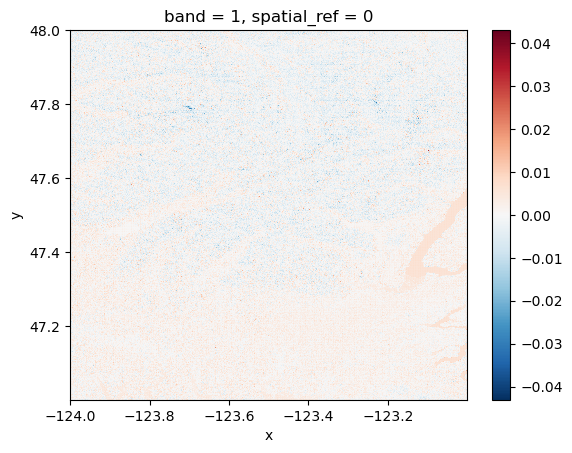

In [15]:
err = (dem_reconst - dem)
err.isel(band=0).plot.imshow()
plt.show()

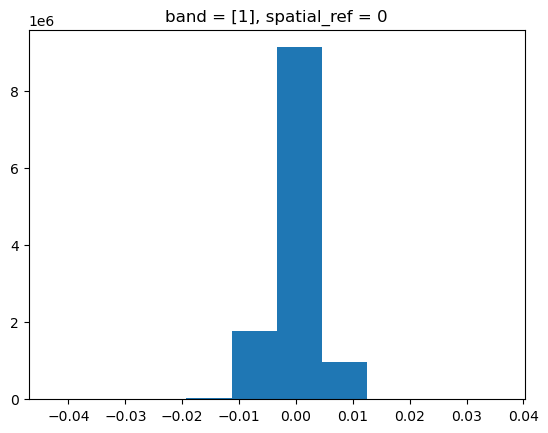

In [16]:
err.plot.hist()
plt.show()

Not bad!

## Reconstruction 2: Getting the latent dimension

A common application of autoencoders is to use the latent dimension for some application. Let's turn our autoencoder's predictions into a data cube. To do so we will modify the batch generator to not have overlapping windows. We also have to slightly clip the size of the input DEM. This is because we are effectively downscaling the spatial axes by a factor of 32. Since `3600 / 32` is not an integer, `predict_on_array` will not know how to rescale the array size. So, we have to clip the DEM to the nearest integer multiple of 32. In this case the nearest multiple is 3584, which we achieve by clipping 8 pixels from each side.

In [17]:
bgen_no_overlap = xbatcher.BatchGenerator(
    dem.isel(x=slice(8, -8), y=slice(8, -8)),
    input_dims=dict(x=32, y=32),
    input_overlap=dict(x=0, y=0)
)

ds_no_overlap = MapDataset(
    X_generator=bgen_no_overlap
)

loader = torch.utils.data.DataLoader(ds_no_overlap, batch_size=16, shuffle=True)

ex_input = next(iter(loader))

# Same as before
print("Input shape:", ex_input.shape)

Input shape: torch.Size([16, 1, 32, 32])


Next we will write a function that the calls the encoder arm of the autoencoder and adds a fake x and y dimension.

In [18]:
def infer_with_encoder(x):
    return m.encoder(x)[:, None, None, :]

ex_output = infer_with_encoder(ex_input)
print("Output shape:", ex_output.shape)

Output shape: torch.Size([16, 1, 1, 64])


Now we combine the outputs together into a new data cube.

In [19]:
latent_dim_cube = functions.predict_on_array(
    dataset=ds_no_overlap,
    model=infer_with_encoder,
    output_tensor_dim=dict(y=1, x=1, channel=64),
    new_dim=["channel"],
    core_dim=[],
    resample_dim=["x", "y"]
)

100%|██████████| 784/784 [00:18<00:00, 43.55it/s]


In [20]:
latent_dim_cube

<xarray.DataArray (y: 112, x: 112, channel: 64)> Size: 6MB
array([[[ 1.28874045e-01,  7.75086625e-02, -5.55759014e-02, ...,
         -3.27143854e-02, -6.68616294e-02,  1.85042192e-01],
        [ 4.90198004e-02, -5.98185952e-02,  4.44655649e-02, ...,
         -5.26558300e-02,  1.11620801e-01,  1.43755537e-02],
        [-9.02844264e-02,  4.53038907e-02,  1.02890299e-01, ...,
         -1.03061418e-01, -2.44774756e-02, -1.26229501e-01],
        ...,
        [ 8.50808569e-02, -4.11381463e-02,  3.22185949e-01, ...,
          2.15229323e-01, -1.61020034e-04, -3.86155116e-01],
        [ 2.42043082e-01, -4.38589390e-01,  9.63557775e-03, ...,
          1.05144160e+00, -1.51818342e-03, -4.17159544e-01],
        [ 1.10649065e-01,  1.34028141e-01, -3.10498728e-01, ...,
         -6.83330255e-01,  1.38356146e-01,  2.94433455e-01]],

       [[ 8.58466967e-02, -3.58534632e-02, -4.34713015e-02, ...,
         -1.64588821e-01, -1.79740433e-02,  9.38760803e-02],
        [-1.11709440e-02,  4.67264983e-02, -8.30549536e-02, ...,
         -9.25415262e-02,  8.19455986e-04,  5.08502062e-02],
        [-1.01654378e-01, -1.58471173e-02, -3.96101929e-02, ...,
          1.19262780e-01, -5.82306653e-02, -1.06923685e-01],
...
          8.05513054e-01, -1.90899603e-02, -2.51008873e-01],
        [-3.05277417e-01, -2.71074913e-01, -3.21921497e-01, ...,
          1.69619096e+00, -1.93046306e-01, -9.82567261e-01],
        [-7.18888233e-01, -4.16569524e-01, -5.89547772e-01, ...,
          1.16380859e-01,  1.42823623e-01,  8.03369825e-02]],

       [[-6.82562327e-01, -3.82883104e-01, -7.59660270e-01, ...,
         -8.27242503e-01,  4.26420546e-01,  4.08618684e-01],
        [-3.48426779e-01, -2.44172212e-01, -8.14472756e-01, ...,
         -5.11244671e-01,  2.56757453e-01,  2.83398354e-01],
        [-1.82507289e-01, -1.61009823e-01, -4.83073501e-01, ...,
         -7.71372122e-01,  2.06676724e-01,  1.64207553e-01],
        ...,
        [-5.14743728e-02,  6.75335458e-02,  1.20770746e-02, ...,
         -5.14311950e-01,  1.64898171e-01, -1.34803013e-03],
        [ 1.17510614e-01, -1.86401018e-01, -1.37048486e-02, ...,
          1.28011505e+00,  6.92394123e-02, -3.04550459e-01],
        [-3.40621438e-01, -4.93242622e-01, -5.45028946e-01, ...,
          2.03157265e-01,  1.42850286e-01,  1.42152573e-02]]],
      shape=(112, 112, 64))
Coordinates:
  * y        (y) float64 896B 48.0 47.99 47.98 47.97 ... 47.04 47.03 47.02 47.01
  * x        (x) float64 896B -124.0 -124.0 -124.0 ... -123.0 -123.0 -123.0
Dimensions without coordinates: channel

Note that despite substantially re-arranging the input `DataArray`, we have retained the coordinate information at a resampled resolution.

If we simply sum the output over the channel dimension, we see that the encoder clearly distinguishes between upland and lowland areas.

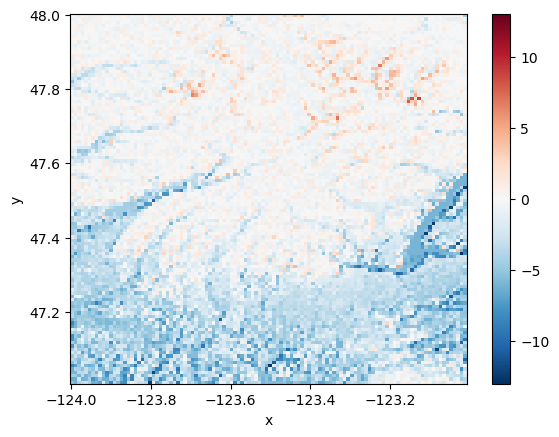

In [21]:
latent_dim_cube.sum(dim="channel").plot.imshow()

As a final demonstration of this workflow, let's compute the cosine similarity of each of the below pixels with the latent encoding of [Mt. Olympus](https://en.wikipedia.org/wiki/Mount_Olympus_(Washington)).

In [22]:
olympus = dict(x=-123.7066, y=47.7998)
olympus_latent = latent_dim_cube.sel(**olympus, method="nearest")
olympus_latent

<xarray.DataArray (channel: 64)> Size: 512B
array([ 0.2827522 , -0.30875602, -0.13335552, -0.24948399, -0.24295124,
        0.10577811,  0.30389504,  0.19009559, -0.16342925, -0.42949802,
        0.23529304, -0.35090051, -0.14595117, -2.07259771,  0.62227102,
       -0.32911838,  0.47812623, -0.97885916,  0.03220614,  0.80411346,
       -4.89141486, -0.26041999, -0.30874618,  3.66279309,  0.35905985,
       -0.77314928, -0.34108844,  0.14015966,  0.28009243,  3.18386946,
        0.41301768,  0.78455269, -6.99761153, -0.16149416,  0.49661396,
        0.4164188 , -0.51689112,  4.08787373, -4.86463934, -0.37827252,
       -0.94250442,  5.97089676,  0.03304775, -0.2362559 ,  0.37190717,
       -0.13821512,  0.20483954,  0.72127774,  0.15716212,  3.34617203,
        0.2457357 ,  2.24839719,  3.9324097 , -0.30229452,  0.37008662,
       -0.93394806, -4.97013094,  0.17824471, -0.20448688,  1.66696003,
       -0.31541562,  0.66030225, -0.25817317, -0.4468631 ])
Coordinates:
    y        float64 8B 47.8
    x        float64 8B -123.7
Dimensions without coordinates: channel

In [23]:
from numpy.linalg import norm

def numpy_cosine_similarity(x, y):
    return np.dot(x, y)/(norm(x)*norm(y))

In [24]:
olympus_similarity = xr.apply_ufunc(
    numpy_cosine_similarity,
    latent_dim_cube,
    input_core_dims = [["channel"]],
    output_core_dims = [[]],
    vectorize=True,
    kwargs=dict(y=olympus_latent.data)
)

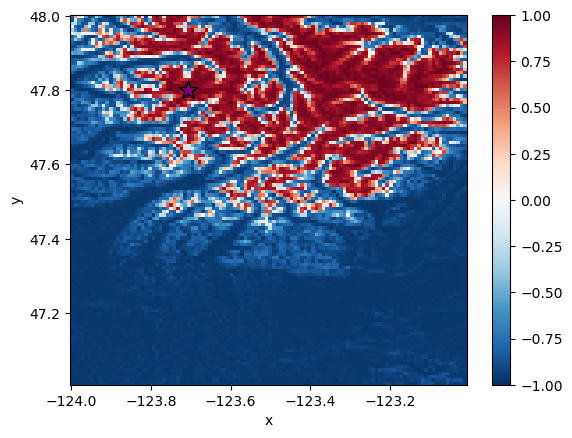

In [25]:
olympus_similarity.plot.imshow()
plt.scatter(olympus["x"], olympus["y"], marker="*", c="purple", edgecolor="black", s=200)
plt.show()

Similarly, we can identify foothills with similar topography to Grisdale, WA.

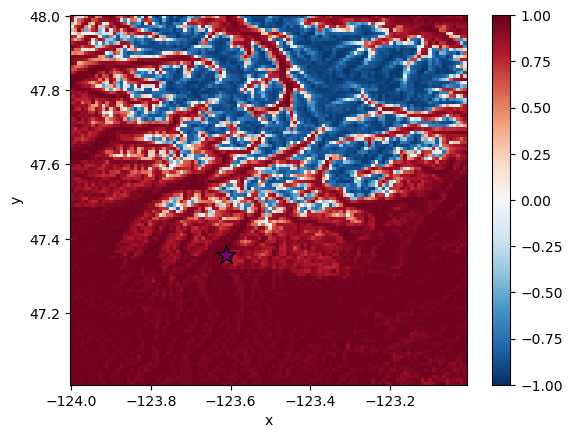

In [26]:
grisdale = dict(y=47.356625678465925, x=-123.61183314426664)
grisdale_latent = latent_dim_cube.sel(**grisdale, method="nearest")

grisdale_similarity = xr.apply_ufunc(
    numpy_cosine_similarity,
    latent_dim_cube,
    input_core_dims = [["channel"]],
    output_core_dims = [[]],
    vectorize=True,
    kwargs=dict(y=grisdale_latent.data)
)

grisdale_similarity.plot.imshow()
plt.scatter(grisdale["x"], grisdale["y"], marker="*", c="purple", edgecolor="black", s=200)
plt.show()

This result is admittedly very similar to if we had just selected elevation bands :)

---

## Summary
Our goal with this notebook has been to show how xbatcher supports linking `xarray` objects with deep learning models, and with converting model output back into labeled `xarray` objects. We have demonstrated two examples of reconstructing model output, both when tensor shape changes and when it does not.

If you encounter any issues, please open an issue on the GitHub repository for this cookbook. Other feedback is welcome!